### 1. Import Packages

In [1]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la Data Imputation
from sklearn.impute import KNNImputer

# Librerie per Data Scaling
from sklearn.preprocessing import MinMaxScaler

# Librerie per la Hyperparameters Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per il Machine Learning
from sklearn.cross_decomposition import PLSRegression
from pyopls import OPLS
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, cross_val_predict

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Librerie per la curva ROC
from sklearn.metrics import roc_curve, auc

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [2]:
df = pd.read_excel('../../../data/ST000369.xlsx')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Idx", "SampleID", "Class"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M172,M173,M174,M175,M176,M177,M178,M179,M180,M181
0,Plasma,Adenocarcinoma,Former,F,194,168,77,105985,118,15489,...,195,1606,300,108,7203,43,59,1009,383,68
1,Plasma,Adenocarcinoma,Former,F,215,143,154,100462,133,13534,...,184,364,1364,160,11910,82,99,136,1021,165
2,Plasma,Adenocarcinoma,Current,F,104,67,45,75301,94,7390,...,189,157,884,73,6372,59,35,115,530,72
3,Plasma,Adenocarcinoma,Current,M,360,642,82,42097,84,50943,...,320,1621,461,104,14011,69,86,845,1309,127
4,Plasma,Adenocarcinoma,Current,M,96,137,95,112346,168,41987,...,84,769,266,158,18140,40,87,1213,1037,149


### 2.1 Data Cleaning

Per quanto riguarda il data cleaning del dataset, sono necessarie due tipologie di operazioni sui dati: 
1. Alcuni valori della feature "*HealthState*" sono scritti incorrettamente, perciò dobbiamo effettuarne la correzione.
2. Tre features binarie sono espresse attraverso stringhe e non valori binari (0 e 1), perciò dobbiamo fare la sostituzione.

In [3]:
# Effettuiamo la correzione dei valori errati
df["HealthState"] = df["HealthState"].str.replace('Adenocarcnoma', 'Adenocarcinoma')

# Eliminiamo le righe con valori nulli all'interno delle colonne "HealthState" e "Sex"
df = df.dropna(subset=["HealthState", "Sex"])

# Convertiamo i valori di natura categorica in valori numerici
df['Output'] = df['HealthState'].apply(lambda x: 1 if x in ['Adenosquamous', 'Adenocarcinoma'] else 0)
df['SmokingStatus'] = df['SmokingStatus'].apply(lambda x: 1 if x in ['Current'] else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x in ['F'] else 0)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M173,M174,M175,M176,M177,M178,M179,M180,M181,Output
0,Plasma,Adenocarcinoma,0,1,194,168,77,105985,118,15489,...,1606,300,108,7203,43,59,1009,383,68,1
1,Plasma,Adenocarcinoma,0,1,215,143,154,100462,133,13534,...,364,1364,160,11910,82,99,136,1021,165,1
2,Plasma,Adenocarcinoma,1,1,104,67,45,75301,94,7390,...,157,884,73,6372,59,35,115,530,72,1
3,Plasma,Adenocarcinoma,1,0,360,642,82,42097,84,50943,...,1621,461,104,14011,69,86,845,1309,127,1
4,Plasma,Adenocarcinoma,1,0,96,137,95,112346,168,41987,...,769,266,158,18140,40,87,1213,1037,149,1


### 3. Extract X & Y

In [4]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
X_features_names = X.columns
y = df.Output

### 3.1 Data Imputation

In [5]:
# KNNImputer
imputer_knn = KNNImputer()
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_17494/4178831705.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X[:] = imputer_knn.fit_transform(X)


### 4. Initial Model Build

In [6]:
minmax = MinMaxScaler()
X_knn = minmax.fit_transform(X_knn)

In [7]:
opls = OPLS(2)
Z = opls.fit_transform(X_knn, y)

In [8]:
pls = PLSRegression(2)

In [9]:
y_pred = cross_val_predict(pls, Z, y, cv=10)
threshold = 0.5
y_pred_class = (y_pred > threshold).astype(int)
roc_auc = metrics.roc_auc_score(y, y_pred_class)

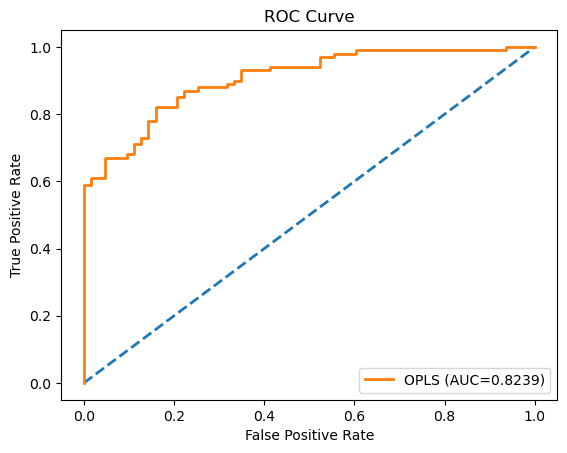

In [10]:
fpr, tpr, thresholds = roc_curve(y, y_pred)

plt.figure(0)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.plot(fpr, tpr, lw=2, label=f'OPLS (AUC={roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [11]:
max_roc_auc_score = 0    
k_best = 0
for k in range(5, 11):

    kfolds = KFold(n_splits=k, shuffle=True, random_state=42)
    pls = PLSRegression()
    y_pred = cross_val_predict(pls, Z, y, cv=kfolds)
    
    # Convertiamo le previsioni in etichette di classe utilizzando una soglia di 0.5
    threshold = 0.5
    y_pred_class = (y_pred[:, 0] > threshold).astype(int)
    
    roc_auc_score = metrics.roc_auc_score(y, y_pred_class)
    
    if roc_auc_score > max_roc_auc_score:
        max_roc_auc_score = roc_auc_score
        k_best = k
    
    print(f"K={k}, Accuratezza Media: {roc_auc_score}")

print("-------------------------------------------")
print(f"K ottimale: {k_best}")
print(f"Accuratezza massima: {max_roc_auc_score}")

K=5, Accuratezza Media: 0.823888888888889
K=6, Accuratezza Media: 0.8368253968253968
K=7, Accuratezza Media: 0.8476984126984127
K=8, Accuratezza Media: 0.8159523809523809
K=9, Accuratezza Media: 0.843888888888889
K=10, Accuratezza Media: 0.8547619047619047
-------------------------------------------
K ottimale: 10
Accuratezza massima: 0.8547619047619047


In [12]:
# Creiamo l'oggetto K-Fold per la Cross-Validation con il numero di fold ottimale
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

In [13]:
# K-Fold Cross Validation del modello con le features ottimali
y_pred = cross_val_predict(pls, Z, y, cv=kfolds)

# Scegliamo una soglia (threshold) per trasformare le probabilità in etichette binarie
threshold = 0.5
y_pred = (y_pred > threshold).astype(int)

# Calcoliamo le metriche
accuracy = metrics.accuracy_score(y, y_pred)
precision = metrics.precision_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)
f1 = metrics.f1_score(y, y_pred)
roc_auc = metrics.roc_auc_score(y, y_pred)

In [14]:
# Stampiamo i risultati
print("------------------------")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print("------------------------")
print(f'Matrice di confusione:\n {metrics.confusion_matrix(y, y_pred)}')
print("------------------------")

------------------------
Accuracy: 0.8650
Precision: 0.8824
Recall: 0.9000
F1-score: 0.8911
ROC AUC: 0.8548
------------------------
Matrice di confusione:
 [[51 12]
 [10 90]]
------------------------


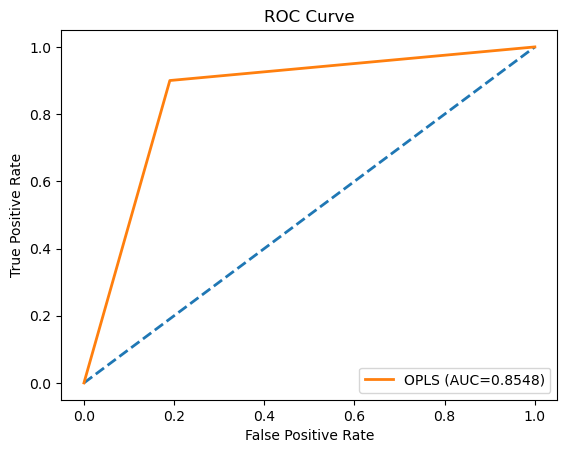

In [15]:
fpr, tpr, thresholds = roc_curve(y, y_pred)

plt.figure(0)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.plot(fpr, tpr, lw=2, label=f'OPLS (AUC={roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()